In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
from matplotlib.colors import LogNorm
import seaborn as sns
import pickle
import matplotlib as mpl
import seaborn as sns
mpl.style.use('/home/apizzuto/Nova/scripts/novae_plots.mplstyle')

from francis.universe.transient_universe import *

# Investigating a redshift cutoff

We have some problems with memory consumption when using FIRESONG and looking at populations of sources with high densities. Markus Ahlers suggested placing a cut on redshift to not need to simulate as many sources.

Below, we investigate how many alert events (and therefore sources for our analysis) we would lose by placing a redshift cut. TL;DR: the redshift cut would only save a factor of ~2 in memory before cutting out about 10% of the sources, so it's not worth it to us

### Simulate the sources

First, we simulate a population of sources and show the distribution as a function of redshift for all of the sources (blue) vs. those that yield an alert event (green)

[0.78908023 1.46159401 2.09135863 2.9723404  5.17254924]
[0.08929744 0.25160439 0.54649391 1.0626541  2.02732722]


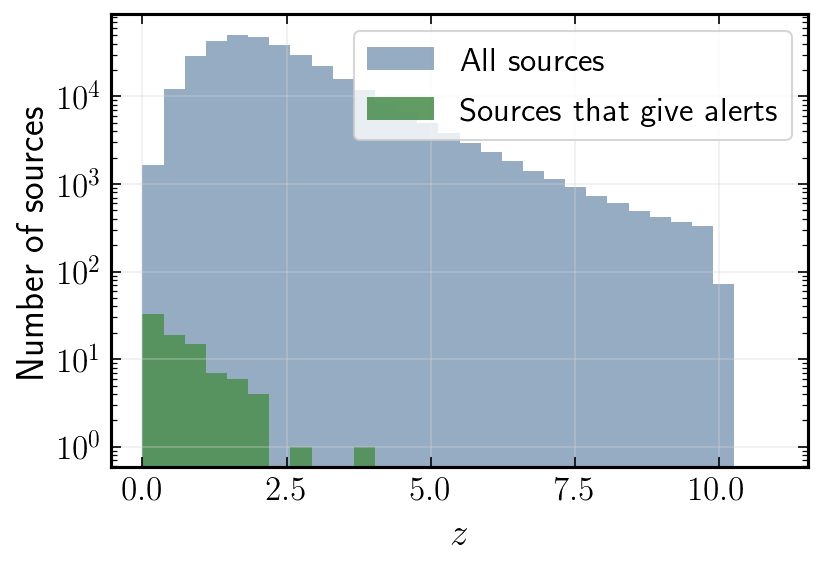

In [48]:
fig = plt.figure(dpi=150)
density = 1e-8
uni = TransientUniverse('SC', 'MD2014SFR', density, 1.5e-8, 2.50, data_years=8.6)

z_bins = np.linspace(0.0, 11., 31)

uni.create_universe()
plt.hist(uni.sources['z'], bins=z_bins, histtype='stepfilled', 
         density=False, lw=2., alpha=0.5, label='All sources', color = sns.xkcd_rgb['light navy blue'])

uni.find_alerts()
plt.hist(uni.sources['z'], bins=z_bins, histtype='stepfilled', density=False, lw=2.,
        alpha=0.9, label='Sources that give alerts', color = sns.xkcd_rgb['light forest green'])

plt.yscale('log')
plt.xlabel(r'$z$')
plt.ylabel('Number of sources')
plt.legend(loc=1)
plt.show()

### Calculate as a function of density

Now, for different densities, we repeat the process above

In [19]:
densities = np.logspace(-11., -6., 21)
ntrials = 20
z_bins = np.linspace(0.0, 11., 51)
levels = [2.5, 16., 50., 84., 97.5]
all_sources_redshifts = []
alert_sources_redshifts = []

for density in densities:
    uni = TransientUniverse('SC', 'MD2014SFR', density, 1.5e-8, 2.50, data_years=8.6)
    all_sources_redshifts.append([])
    alert_sources_redshifts.append([])
    for trial in range(ntrials):
        uni.create_universe()
        all_sources_redshifts[-1].append(np.percentile(uni.sources['z'], levels))
        uni.find_alerts()
        alert_sources_redshifts[-1].append(np.percentile(uni.sources['z'], levels))

1e-11 1.7782794100389227e-11 3.1622776601683794e-11 5.6234132519034906e-11 1e-10 1.778279410038923e-10 3.1622776601683795e-10 5.623413251903491e-10 1e-09 1.7782794100389228e-09 3.1622776601683795e-09 5.623413251903491e-09 1e-08 1.7782794100389228e-08 3.162277660168379e-08 5.6234132519034905e-08 1e-07 1.7782794100389227e-07 3.162277660168379e-07 5.62341325190349e-07 1e-06


In [20]:
all_sources_redshifts = np.asarray(all_sources_redshifts)
alert_sources_redshifts = np.asarray(alert_sources_redshifts)

In [27]:
ave_all_sources = np.mean(all_sources_redshifts, axis=1)
ave_alerts = np.mean(alert_sources_redshifts, axis=1)

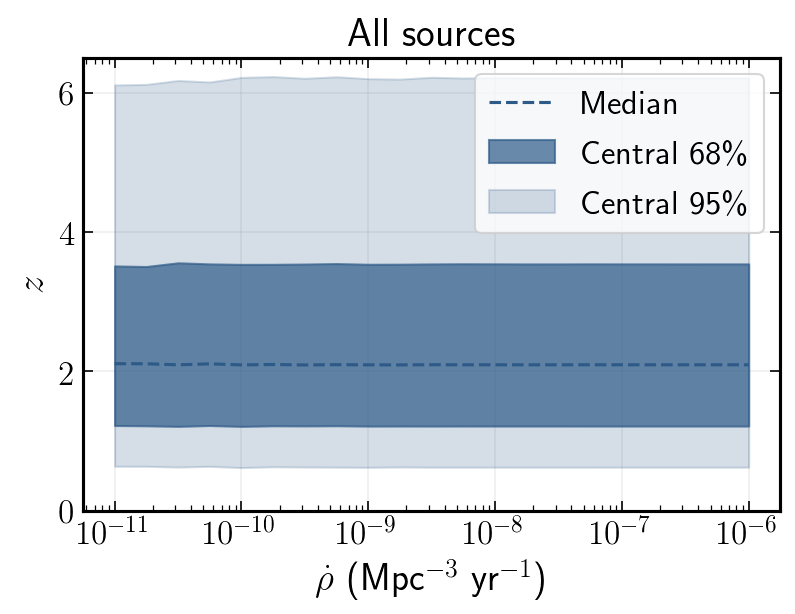

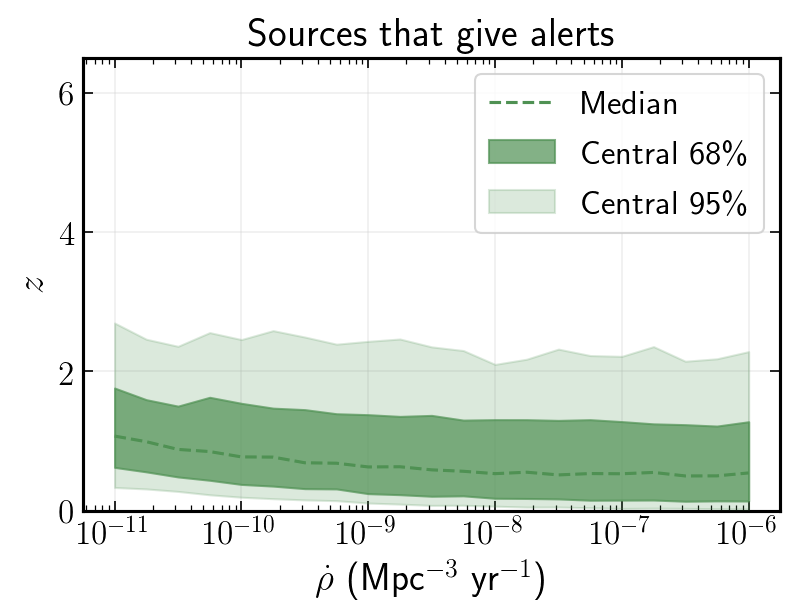

In [44]:
for source_cat, col, zord, name in zip([ave_all_sources, ave_alerts], 
                               ['light navy blue', 'light forest green'], [3, 3], 
                               ['All sources', 'Sources that give alerts']):
    fig = plt.figure(dpi=150)
    plt.plot(densities, source_cat.T[2], ls='--', color=sns.xkcd_rgb[col], label = 'Median')
    for ii, alpha, perc in zip([0, 1], [0.7, 0.2], ['68', '95']):
        plt.fill_between(densities, source_cat.T[2-(ii+1)], source_cat.T[2+ii+1], 
                         alpha=alpha, color=sns.xkcd_rgb[col], zorder=zord,
                        label='Central {}\%'.format(perc))

    plt.xscale('log')
    plt.xlabel(r'$\dot{\rho}$ (Mpc$^{-3}$ yr$^{-1}$)')
    plt.ylabel(r'$z$')
    plt.ylim(0.0, 6.5)
    plt.title(name)
    plt.legend(loc=1, frameon=True)

    plt.show()

The plots above show the central 68% and 95% containment of the redshift distributions as a function of density. If we are willing to sacrifice 5% of our signal (alert events), that corresponds to placing a cut at the redshift of ~2.5, where the light green distribution cuts off. Looking at where that falls in the all source distribution, it is where the median falls, meaning we would save a factor of 2 in the number of sources we need to simulate (and therefore in memory)

However, the memory problems we run into are more sever than that, we need to save a factor of ~10 in memory. As we are already cutting into our signal significantly with a factor of 2 in memory, this does not seem worth it to us